In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
import openpyxl
from netCDF4 import Dataset
import h5netcdf

In [3]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Fedchenko.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [4]:
#Gra Mera 5km
sourceData='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRf/spin2/work/monthly/'
variable='TTZ' ##RF;SF;SHSN3;TT
fileNameM='TTZ_mon_MARv3.14_ER5_spin2_GRf_2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TTZ'][:,1,:,:] ## montlhy mean

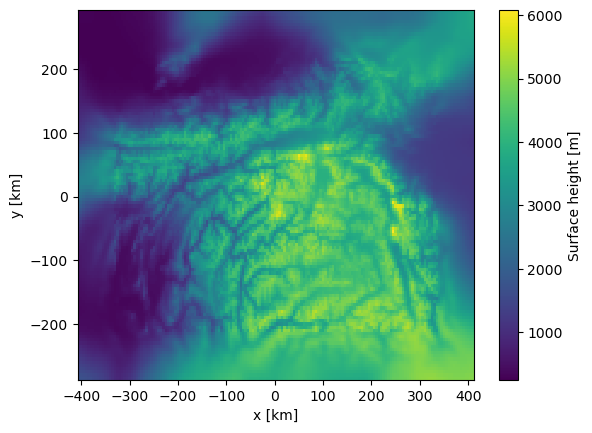

In [5]:
ds_grM['SH'].plot()

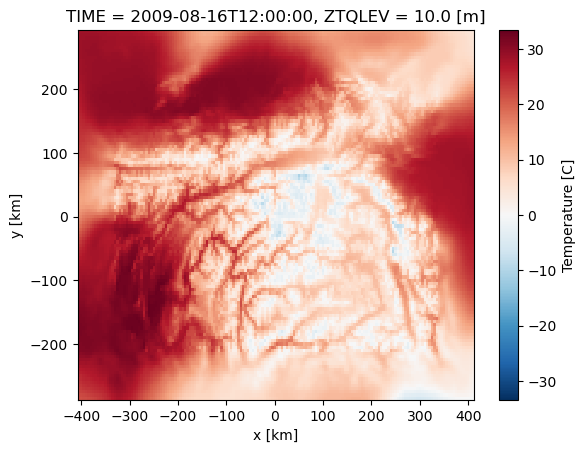

In [6]:
dsM[115,:,:].plot()

In [7]:
dsM

<xarray.DataArray 'TTZ' (TIME: 288, Y: 116, X: 164)> Size: 22MB
[5478912 values with dtype=float32]
Coordinates:
  * TIME     (TIME) datetime64[ns] 2kB 2000-01-16T12:00:00 ... 2023-12-16T12:...
  * X        (X) float32 656B -405.0 -400.0 -395.0 -390.0 ... 400.0 405.0 410.0
  * Y        (Y) float32 464B -285.0 -280.0 -275.0 -270.0 ... 280.0 285.0 290.0
    ZTQLEV   float32 4B 10.0
Attributes:
    long_name:     Temperature
    units:         C
    cell_methods:  TIME: mean
    history:       From ICE.f98.2000.01.01-31

In [8]:
###
#AWS-Mera La: Since November 2013 (AWS inserted on firm rocks – off-glacier)
#Location in WGS84, Lat: 27.735°N; Long: 86.900°E; Elevation: 5352.008 m 
#or UTM Zone 45; Easting: 490137.007 m; Northing: 3067850.613 m on 22/11/2020
###
lon_Fed=72.2696
lat_Fed=38.5453
elev_Fed=5390
##Find the pixel of MAR corresponding to station
target_lon = lon_Fed
target_lat = lat_Fed
lon=ds_grM.LON
lat=ds_grM.LAT

In [9]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.078226 , 5.0283036, 4.978513 , ..., 5.0818653, 5.1319246,
        5.1821036],
       [5.0595946, 5.009453 , 4.9594097, ..., 5.063239 , 5.1135206,
        5.1639156],
       [5.041286 , 4.990921 , 4.940666 , ..., 5.0449433, 5.0954447,
        5.1460624],
       ...,
       [5.5030723, 5.452244 , 5.4015703, ..., 5.505305 , 5.5563   ,
        5.607445 ],
       [5.5278125, 5.4771676, 5.426686 , ..., 5.5300245, 5.5808396,
        5.6318183],
       [5.5528135, 5.502343 , 5.4520445, ..., 5.555002 , 5.605633 ,
        5.656445 ]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -405.0 -400.0 -395.0 -390.0 ... 400.0 405.0 410.0
  * y        (y) float32 464B -285.0 -280.0 -275.0 -270.0 ... 280.0 285.0 290.0


In [10]:
print(j,i)

51 80


In [11]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, j, i]





dsM_sta_new= dsM_sta.rename({'TIME': 'time'})

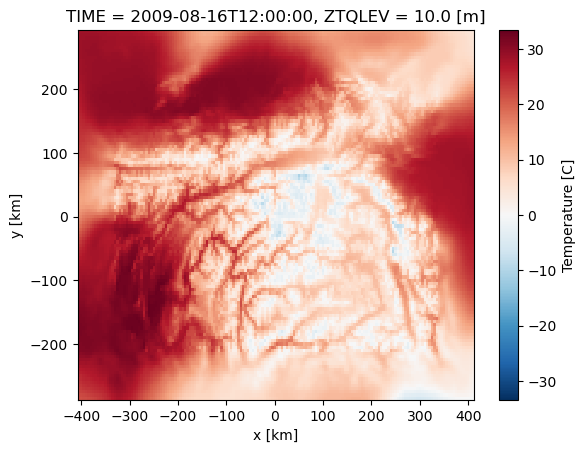

In [12]:
dsM[115,:,:].plot()

In [13]:
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Fed
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
diff,value.values

(np.float32(66.23389), array(5323.766, dtype=float32))

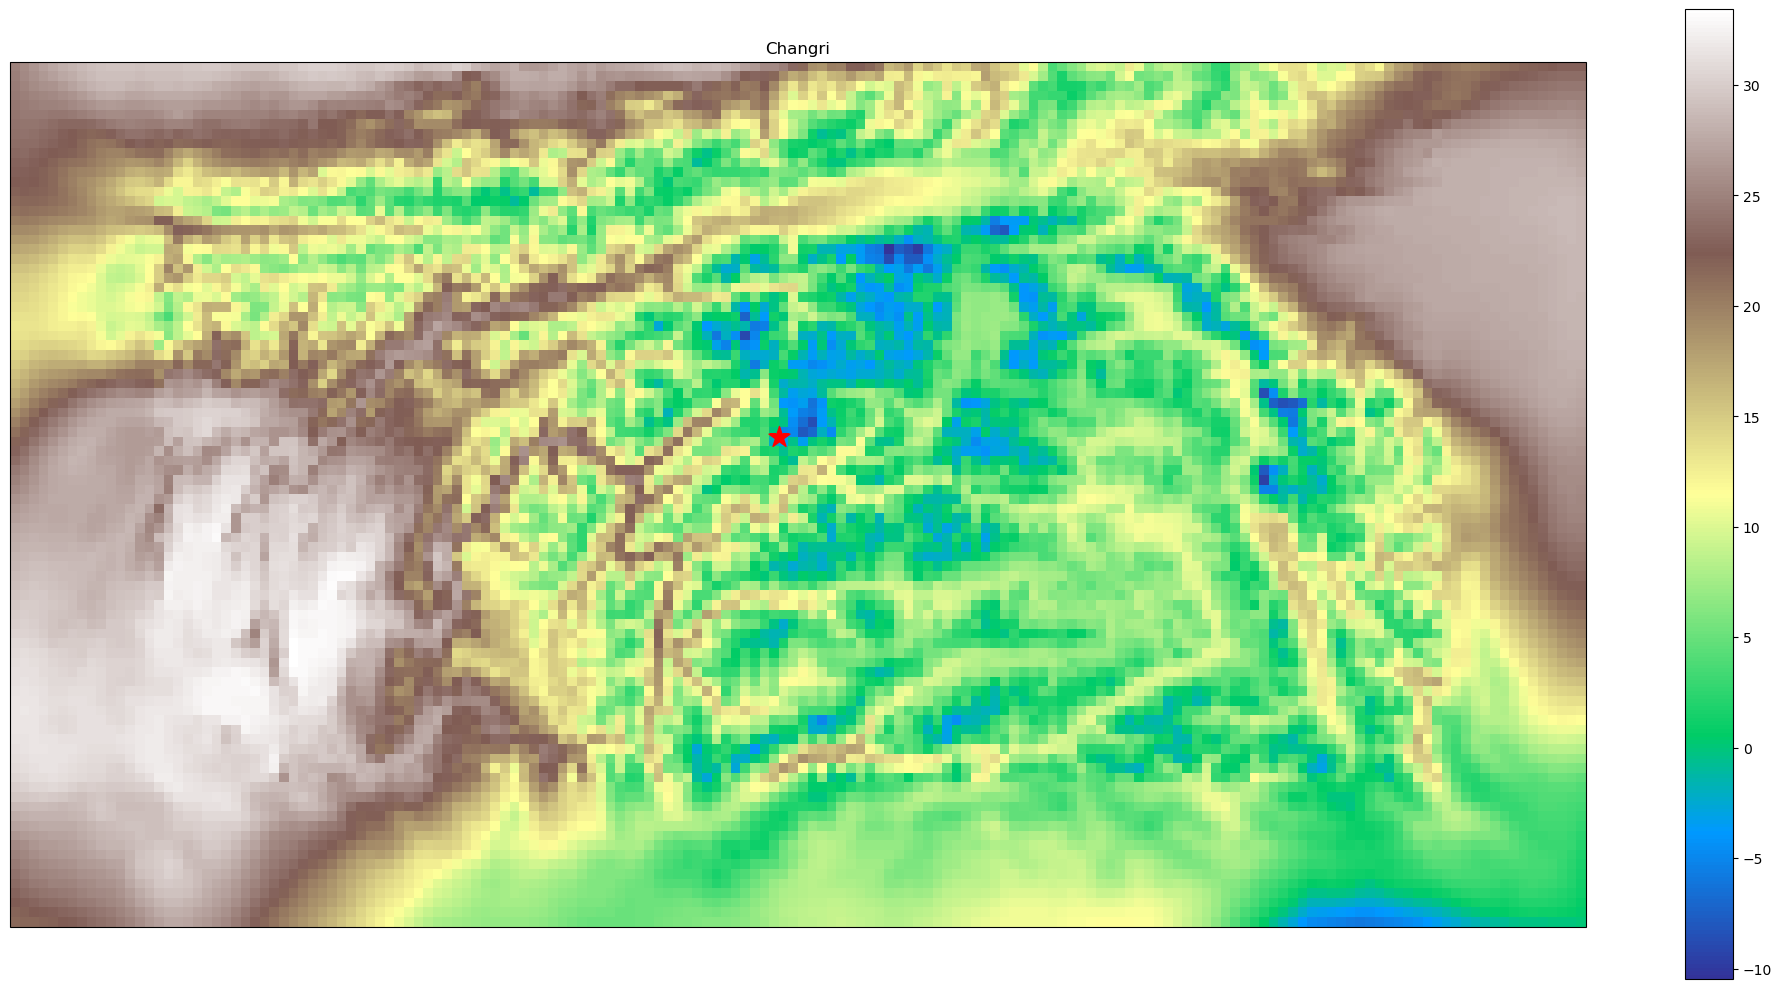

In [14]:
##
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(20,10))
cmap='terrain'

m1=axs.pcolormesh(dsM[115,:,:],cmap=cmap)
axs.scatter(i,j,s=250,marker='*',color='red',linewidths=1.,edgecolors='red') #vérifier si coordonées sont dans le bon référenciel.

axs.set_title('Changri')
fig.colorbar(m1,orientation='vertical')

#ax1.set_title('contourf with levels')
fig.tight_layout()

plt.show()

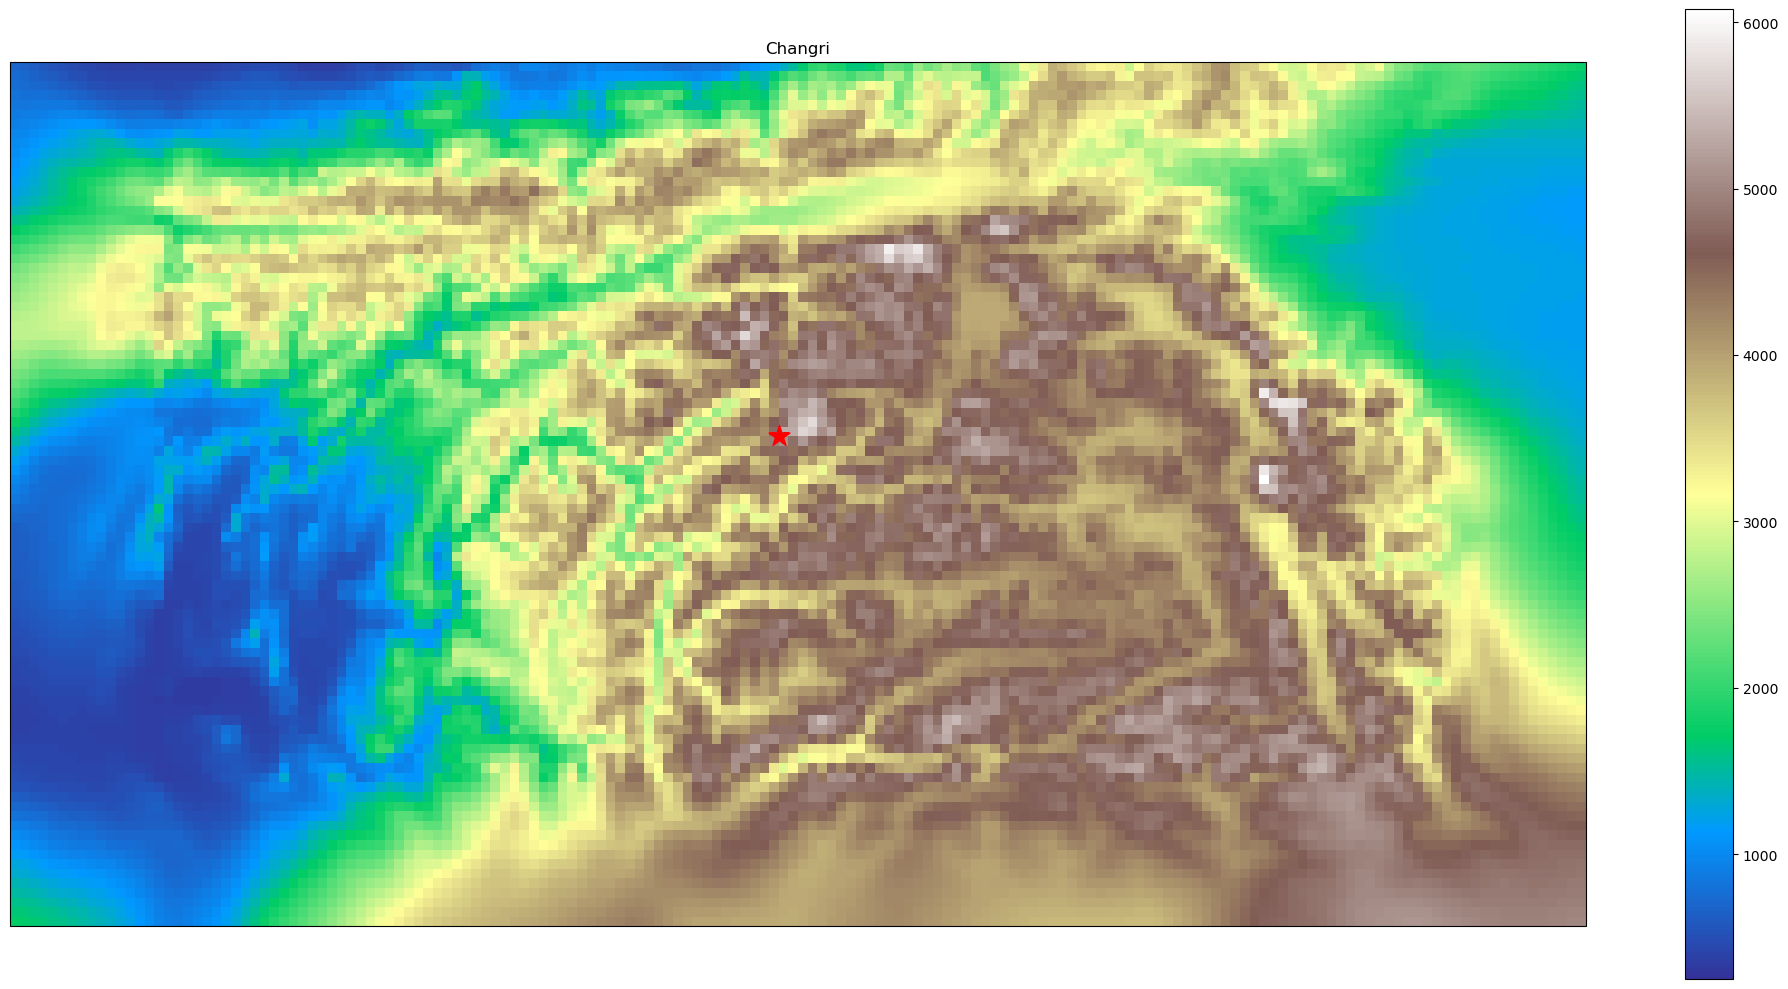

In [15]:
##
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(20,10))
cmap='terrain'

m1=axs.pcolormesh(ds_grM.SH,cmap=cmap)
axs.scatter(i,j,s=250,marker='*',color='red',linewidths=1.,edgecolors='red') #vérifier si coordonées sont dans le bon référenciel.

axs.set_title('Changri')
fig.colorbar(m1,orientation='vertical')

#ax1.set_title('contourf with levels')
fig.tight_layout()

plt.show()

In [16]:
####
## Opening station data
####

In [17]:
sourceData='/bettik/PROJECTS/pr-regional-climate/rambaand/Data/'
fileName='Fed_Meteo5400m_VAizen_60min.xlsx'
xl_file = pd.ExcelFile(sourceData+fileName)
print(xl_file)

In [18]:
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
DataMeraLa=dfs['Fedchenko_MetData_60min_2019-08']

NameVars=['Time','N°','u','Winddir1','Winddir2','Windgust','SolarRad','Tair','RH','Patm','Tairsum']
UnitVars=['data/hour','Nona','m/s','degrees','degrees','Dunno','W/m2','°C','%','hPa','°C']

##Define new DataFrame and changing name of columns
dfile = pd.DataFrame(data=DataMeraLa.loc[5:])
df=pd.DataFrame(dfile.values, columns=NameVars)
df['Time'] = df['Time'].dt.round('h')
### Opening one column + converting into an array



In [19]:
def NewTime(df, NameVar, values, freq):
	time = pd.to_datetime(df['Time'].values)
	ds = xr.Dataset({NameVar: ("time", np.asarray(values))}, coords={"time": time})
	return ds
# Time step: 1h

Tair_ar=[float(i) for i in df.Tair.values]

T=NewTime(df,'Tair',Tair_ar,'1h')

In [20]:
daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()
#daily_meanTM

In [21]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [22]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 2013-11-15 fin 2024-11-28
time2 = dsM_sta_new['time'] # début 2003-01-01T12: fin 2013-12-31T12
start=time1[0] 
end=time1[-1]

In [23]:
ts_sta=monthly_meanT.sel(time=slice(start,end))
ts_MAR=dsM_sta_new.sel(time=slice(start,end))

#Annual cycle:
Tsta_cycle=ts_sta.groupby('time.dayofyear').mean()

TMAR_daily_cycle=ts_MAR.groupby('time.dayofyear').mean()
plt.plot(Tsta_daily_cycle.dayofyear,Tsta_daily_cycle.Tair,     
    color='darkblue',linestyle='-',label='Tair')
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Day of year')
plt.ylabel('Température (°C)')
#Annual cycle:
plt.plot(TMAR_daily_cycle.dayofyear,TMAR_daily_cycle.values,    
    color='red',linestyle='-',label='Tair MAR')
plt.legend()
plt.grid(True)




In [24]:
Tsta_monthly_cycle=monthly_meanT.groupby('time.month').mean()
TMAR_monthly_cycle=dsM_sta_new.groupby('time.month').mean()

In [25]:
Tsta_premon = seasonsdata(ts_sta, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(ts_sta, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(ts_sta, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(ts_sta, 'DJF').groupby('time.month').mean()


In [26]:
#Time series annual data sta
Timeseries_Tsta_premon = seasonsdata(ts_sta, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_Tsta_mon = seasonsdata(ts_sta, 'JJAS').resample(time='YE').mean()
Timeseries_Tsta_postmon =  seasonsdata(ts_sta, 'ON').resample(time='YE').mean()
Timeseries_Tsta_hiver  = seasonsdata(ts_sta, 'DJF').resample(time='YE').mean()

In [27]:
#dsM_sta_new


TMAR_premon = seasonsdata(ts_MAR, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(ts_MAR, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(ts_MAR, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').groupby('time.month').mean()





In [28]:
#Time series annual data MAR 
Timeseries_TMAR_premon = seasonsdata(ts_MAR, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_TMAR_mon = seasonsdata(ts_MAR, 'JJAS').resample(time='YE').mean()
Timeseries_TMAR_postmon =  seasonsdata(ts_MAR, 'ON').resample(time='YE').mean()
Timeseries_TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').resample(time='YE').mean()


66.23389


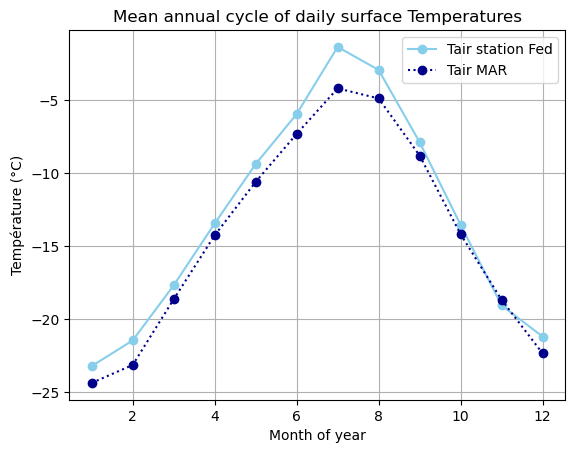

In [31]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='skyblue',linestyle='-',label='Tair station Fed',marker='o')

plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
    color='darkblue',linestyle=':',label='Tair MAR',marker='o')
plt.legend()
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)
print(diff)

#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Tsta_premon.month, Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax1.plot(TMAR_premon.month, TMAR_premon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Tsta_mon.month, Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax2.plot(TMAR_mon.month, TMAR_mon.values, linestyle=':', marker= 'o', label='Tair')
ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Tsta_postmon.month, Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax3.plot(TMAR_postmon.month, TMAR_postmon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Tsta_hiver.month, Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax4.plot(TMAR_hiver.month, TMAR_hiver.values, linestyle=':', marker= 'o', label='Tair MAR')
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()


fig.suptitle('Seasonsal Comparaisons between MAR model and MeraLa stations data')

In [ ]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values, linestyle='-', marker= 'o', label='Tair Station Fed')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')


ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values, linestyle='-',marker= 'o', label='Tair Station Fed')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values, linestyle=':',color='darkblue', marker= 'o', label='Tair')


ax2.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values, linestyle='-', marker= 'o', label='Tair Station Fed')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')



ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, linestyle='-', marker= 'o', label='Tair Station Fed')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and MeraLa stations data',fontsize=20)


fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLa')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax1.plot(Timeseries_Tsta_premon.time, linTsta_premon.intercept + linTsta_premon.slope*xtime15_24, 'cyan', label='line regress Tair MeraLa')
ax1.plot(Timeseries_Tsta_premon.time, linTMAR_premon.intercept + linTMAR_premon.slope*xtime15_24, 'blue', label='line regress Tair MAR')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values, linestyle=':',marker= 'o', label='Tair Station MeraLA')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values, linestyle=':',color='darkblue', marker= 'o', label='Tair')

ax2.plot(Timeseries_Tsta_mon.time, linTsta_mon.intercept + linTsta_mon.slope*xtime15_24, 'cyan', label='line regress Tair MeraLa')
ax2.plot(Timeseries_TMAR_mon.time, linTMAR_mon.intercept + linTMAR_mon.slope*xtime15_24, 'blue', label='line regress Tair MAR')


ax2.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax3.plot(Timeseries_Tsta_postmon.time, linTsta_postmon.intercept + linTsta_postmon.slope*xtime14_24, 'cyan', label='line regress Tair MeraLa')
ax3.plot(Timeseries_TMAR_postmon.time, linTMAR_postmon.intercept + linTMAR_postmon.slope*xtime15_24, 'blue', label='line regress Tair MAR')


ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax4.plot(Timeseries_Tsta_hiver.time, linTsta_hiver.intercept + linTsta_hiver.slope*xtime14_24, 'cyan', label='line regress Tair MeraLa')
ax4.plot(Timeseries_TMAR_hiver.time, linTMAR_hiver.intercept + linTMAR_hiver.slope*xtime14_24, 'blue', label='line regress Tair MAR')

ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and MeraLa stations data',fontsize=20)